## Phase 1

open file:<br>
`gunzip DS_dataset_11.9.gz`<br>
`mv DS_dataset_11.9 DS_dataset_11.9.csv`

1.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('DS_dataset_11_9.csv')

In [86]:
df.shape

(290991, 7)

In [5]:
df.head()

,request_time,browser,os,state,web_site,user_identifier,label
0,2019-11-13 19:20:16.143 UTC,CHROME62,MAC_OS_X,GA,dlnet.com,106.73.3,0
1,2019-11-13 19:20:16.134 UTC,CHROME62,MAC_OS_X,GA,dlnet.com,106.73.3,0
2,2019-11-13 19:52:50.808 UTC,CHROME62,MAC_OS_X,GA,dlnet.com,106.73.3,0
3,2019-10-27 17:20:40.755 UTC,CHROME62,CHROME_OS,NJ,redditt.com,215.89.81,0
4,2019-10-17 07:19:16.969 UTC,CHROME62,MAC_OS_X,MD,citationmachine.com,39.232.17,0


In [3]:
df = df.rename(columns={'label':'did_click'})

In [4]:
df['profit'] = -1 + 60 * df.did_click

In [10]:
df.profit.sum()

-2331

So, overall not proftable. But let's break it down.

2.

In [12]:
df.groupby('browser')['profit'].sum().sort_values()

browser
CHROME64    -40322
CHROME77    -37557
CHROME66     -9307
CHROME74     -1445
CHROME68     -1428
CHROME69     -1372
CHROME72     -1303
CHROME73     -1230
FIREFOX66    -1079
FIREFOX67     -980
CHROME67      -278
CHROME63       103
CHROME71       106
CHROME62       110
CHROME70       211
CHROME65       238
CHROME75       836
FIREFOX68     1564
CHROME76      4518
FIREFOX69    16410
FIREFOX70    21069
CHROME78     48805
Name: profit, dtype: int64

It looks like newer versions of Firefox are the most profitable - their profit is in exact version order. Chrome is a bit of a mixed bag, the newest version is the most profitable but the one before that was the second-biggest money loser

Let's look at browsers overall:

In [5]:
df['browser_type'] = df.browser.str[:-2]

In [6]:
df.groupby('browser_type')['profit'].sum().sort_values()

browser_type
CHROME    -39315
FIREFOX    36984
Name: profit, dtype: int64

As expected, Firefox is profitable overall, Chrome loses money overall.

3.

In [7]:
df.groupby('web_site')['profit'].sum().sort_values()

web_site
hdpopcorns.co     -107577
cyberreel.com      -45170
fmovies.se          -2501
imdark.com          -2094
searchsafe.co       -1536
                    ...  
netbenifits.com      1569
xifinity.com         1706
scribble.io          4183
lapcorp.com          4629
barclayus.com        8590
Name: profit, Length: 7427, dtype: int64

In [8]:
x = _

In [9]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

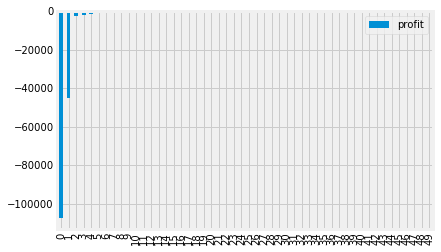

In [10]:
x.head(50).reset_index().plot.bar();

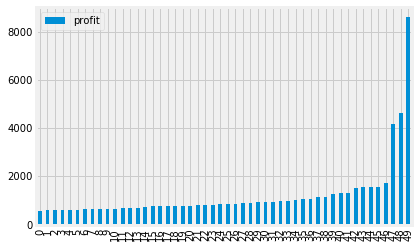

In [54]:
x.tail(50).reset_index().plot.bar();

We see that the two biggest losers (`hdpopcorns.co` and `cyberreel.com`) have a massively outsized impact on growth (a 'hockey-stick' graph). The three biggest winners are also very significant, though the effect is not as great. 

If we disregard the two big losers, are we profitable overall?

In [90]:
df.loc[~df.web_site.isin(['hdpopcorns.co', 'cyberreel.com']), 'profit'].sum()

150416

Yes!

## Phase 2

1.

Adding some features

In [12]:
df.request_time = pd.to_datetime(df.request_time)
df['dayofweek'] = df.request_time.dt.dayofweek
df['hour'] = df.request_time.dt.hour
df['is_weekend'] = df.dayofweek.isin([5, 6])  # monday is 0

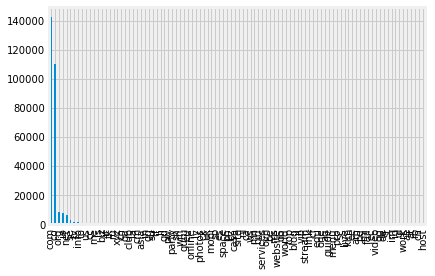

In [13]:
df['tld'] = df.web_site.apply(lambda x: x.split('.')[-1])
df.tld.value_counts().plot.bar();

In [96]:
df.tld.value_counts().head()

com    142365
co     110325
org      8316
io       7542
net      6566
Name: tld, dtype: int64

`com` and `co` are the most popular by far, let's keep only those and do one-hot encoding

In [14]:
df.loc[~df.tld.isin(['com', 'co']), 'tld'] = 'other'

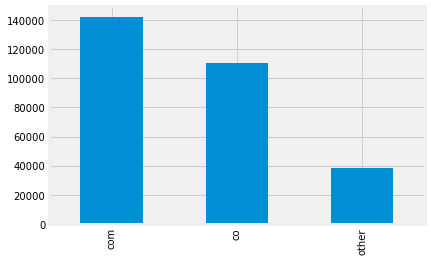

In [98]:
df.tld.value_counts().plot.bar();

Looking at other correlations

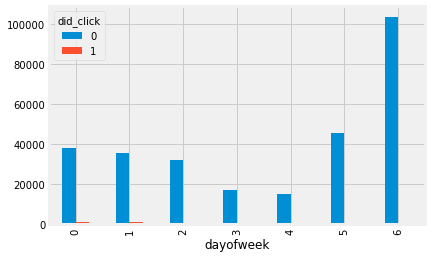

In [123]:
pd.crosstab(df.dayofweek, df.did_click).plot.bar();

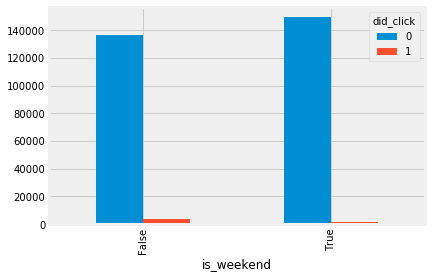

In [128]:
pd.crosstab(df.is_weekend, df.did_click).plot.bar();

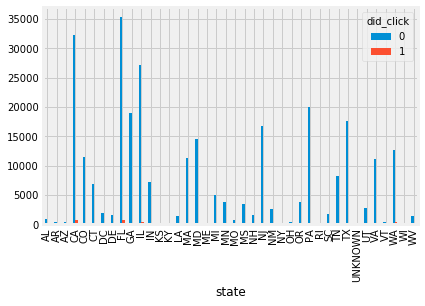

In [129]:
pd.crosstab(df.state, df.did_click).plot.bar();

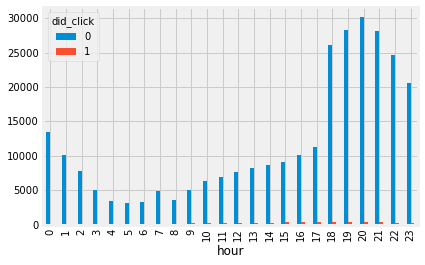

In [130]:
pd.crosstab(df.hour, df.did_click).plot.bar();

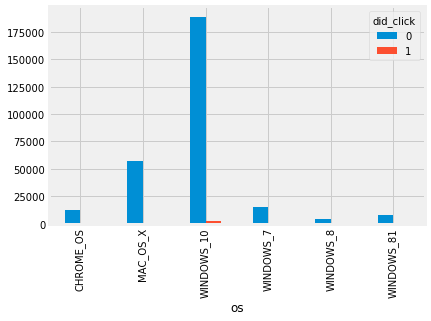

In [131]:
pd.crosstab(df.os, df.did_click).plot.bar();

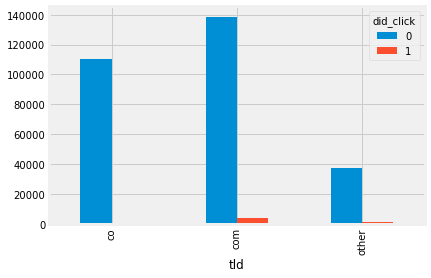

In [126]:
pd.crosstab(df.tld, df.did_click).plot.bar();

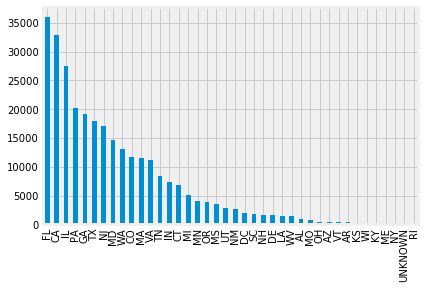

In [144]:
df.state.value_counts().plot.bar();

Let's take the top 10 states, so that we don't end up with too many categorical values and a sparse matrix

In [16]:
top_10 = df.state.value_counts().head(10).index

In [17]:
df.state.isin(top_10).sum() / len(df)

0.7230120519191315

In [18]:
df.loc[~df.state.isin(top_10), 'state'] = 'other'

Choosing features

In [22]:
X = df.drop(columns=['request_time', 'user_identifier', 'did_click', 'profit', 'browser_type', 'web_site']).copy()
y = df.did_click.copy()

In [23]:
X.head()

,browser,os,state,dayofweek,hour,is_weekend,tld
0,CHROME62,MAC_OS_X,GA,2,19,False,com
1,CHROME62,MAC_OS_X,GA,2,19,False,com
2,CHROME62,MAC_OS_X,GA,2,19,False,com
3,CHROME62,CHROME_OS,NJ,6,17,True,com
4,CHROME62,MAC_OS_X,MD,3,7,False,com


In [24]:
categoricals = list(X)
for c in categoricals:
    dummies = pd.get_dummies(X[c], prefix=c)
    X_ = X.join(dummies)
    X = X_

In [25]:
X.head()

,browser,os,state,dayofweek,hour,is_weekend,tld,browser_CHROME62,browser_CHROME63,browser_CHROME64,...,hour_19,hour_20,hour_21,hour_22,hour_23,is_weekend_False,is_weekend_True,tld_co,tld_com,tld_other
0,CHROME62,MAC_OS_X,GA,2,19,False,com,1,0,0,...,1,0,0,0,0,1,0,0,1,0
1,CHROME62,MAC_OS_X,GA,2,19,False,com,1,0,0,...,1,0,0,0,0,1,0,0,1,0
2,CHROME62,MAC_OS_X,GA,2,19,False,com,1,0,0,...,1,0,0,0,0,1,0,0,1,0
3,CHROME62,CHROME_OS,NJ,6,17,True,com,1,0,0,...,0,0,0,0,0,0,1,0,1,0
4,CHROME62,MAC_OS_X,MD,3,7,False,com,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [32]:
X = X[[c for c in list(X) if c not in categoricals]]

In [34]:
X.dtypes.unique()

array([dtype('uint8')], dtype=object)

Great, now we have only ints for our model

Normalized value counts of dependent variable:

In [121]:
df.did_click.value_counts() / len(df)

0    0.983467
1    0.016533
Name: did_click, dtype: float64

Very imbalanced data! (Not surprising considering the imbalance in payoff) We need to do something about this, we will do upsampling with SMOTE.

In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [37]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

In [42]:
os_data_y.y.value_counts()

1    200360
0    200360
Name: y, dtype: int64

Great! Balanced data

![balance](balance1.jpg)

In [46]:
X, y = os_data_X, os_data_y

2.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\user\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Miniconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Miniconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = logreg.predict(X_test)

In [49]:
print('Accuracy: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy: 0.96


Let's try another model to be safe

In [51]:
import xgboost as xgb

In [52]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

[21:26:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [53]:
y_pred = xgb_model.predict(X_test)

In [54]:
print('Accuracy: {:.2f}'.format(xgb_model.score(X_test, y_test)))

Accuracy: 0.61


Wow! way worse score than Logit regression

3.

This score uses mean accuracy. Alternative ways to measure are mean squared / absolute error, as well as precision/recall, ROC/AUC, etc. All of these are included in sklearn, but I'll stop here